# Homework 4: Sensitivity Analysis - Due March 31 Mid Night

Covers Lecture 14. 

1. Conduct sensitivity analysis with the analytical function

$y=f(x)+\sin(2\pi x_1-\pi)+7\sin^2(2\pi x_2-\pi)+0.1(2\pi x_3-\pi)^4\sin(2\pi x_1-\pi)$

where the input vector x is uncertain. This uncertainty is characterized by the following distributions:

$x_1 \sim Unif[0,1]$

$x_2 \sim Normal(0.5,0.2)$

$x_3 \sim Unif[2,3]$

with all of teh $x_j$ mutually independent.

1 (a): Generate an Lattin Hypercube Sample of size $n=1000$ and make scatterplots for the output versus the 3 input variables.

1 (b): Use the Sobol method to conduct sensitivity analsyis and calculate the total effect variance indices for the three inputs using the Sobol method. 

1 (c): Use pie chart or bin chart to visualize the total effect variance indices. 

Hint: You can use the Python Sensitivity Analysis Library https://github.com/SALib/SALib or you can use the R sensitivity package https://cran.r-project.org/web/packages/sensitivity/sensitivity.pdf.

2 Let's reconsider the problem in HW2 (you can use the Python code that you have developed in HW2):


Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}T(x)\right) = 0,
$$
and boundary values:
$$
T(0) = 1\;\mbox{and}\;T(1) = 0.
$$

We are interested in cases in which we are uncertain about the conductivity, $c(x)$.
Before we proceed, we need to put together all our prior beliefs and come up with a stochastic model for $c(x)$ that represents our uncertainty.
This requires assigning a probability measure on a function space (the subject of [Lecture 9](../lectures/lec_09.ipynb)).
For now, we will just give you a model.
We will model $c = c(x;\boldsymbol{\xi})$ as:
$$
c(x;\boldsymbol{\xi}) = c_0(x)\exp\{g(x;\boldsymbol{\xi})\},
$$
where $k_0(x)$ is a "mean" conductivity level and $g(x;\boldsymbol{\xi})$ is a random field.
The reason for the exponential is that $k(x;\boldsymbol{x})$ must be positive.
Assume that $g(x;\boldsymbol{\xi})$ has the following form:
$$
g(x;\boldsymbol{\xi}) = \sum_{i=1}^\infty\xi_i\phi_i(x),
$$
where $\phi_i(x)$ are functions of $x$ and $\xi_i$ are independent standard normal random variables with zero mean and unit variance.
For this particular example, we will assume that:
$$
\phi_i(x) = \frac{\sqrt{2}\sigma}{(i - \frac{1}{2})\pi}\sin\left((i-\frac{1}{2})\pi x\right),
$$
where $\sigma>0$ is a parameter controlling the variance of the random field.
For the record, this corresponds to a random field known as the [Wiener-Lévy process](https://en.wikipedia.org/wiki/Wiener_process).
Since, we cannot actually work with the infinite sums, let's truncate at $i=d$ and define:
$$
g_d(x;\boldsymbol{\xi}) = \sum_{i=1}^d\xi_i\phi_i(x).
$$
Let's implement the field:

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# This computes the random field given a xi
def g(x, xi, sigma=1.):
    """
    Arguments:
    x     -   One dimensional vector containing the points at which you wish to evaluate the field.
    xi    -   One dimensional vector of the random variables. The dimensionality of this vector
              corresponds to the ``d`` in the math above.
    sigma -   This is the variance of the field.
    """
    res = np.zeros(x.shape[0])
    d = xi.shape[0]
    for i in xrange(d):
        res += xi[i] * math.sqrt(2) * sigma / (i - .5) / math.pi * np.sin((i - .5) * math.pi * x)
    return res

C:\Users\Guang\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


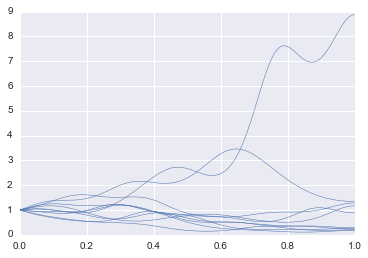

In [4]:
# Take some samples now
x = np.linspace(0, 1, 100)
d = 10
fig, ax = plt.subplots()
for i in xrange(10):
    xi = np.random.randn(d)
    ax.plot(x, np.exp(g(x, xi)), color=sns.color_palette()[0], linewidth=0.5)
plt.show()

We need to create a solver. We will develop a solver based on the [finite volume method](https://en.wikipedia.org/wiki/Finite_volume_method) using [FiPy](http://www.ctcms.nist.gov/fipy).
You have to install the following packages:
```
pip install ez_setup
pip install fipy
```
Here is the solver:

In [ ]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, nx=100, value_left=1., value_right=0.):
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        g_val = g(x, xi)
        self.C.setValue(np.exp(g_val))
        self.eq.solve(var=self.phi)
        return self.phi.value.flatten()

The output quantity of interest is $T(x=0.5)$. Consider the number of dimensionality for $c(x;\xi)$ is $10$. 

Question: 
2 (a): Generate an Lattin Hypercube Sample of size $n=100$.

2 (b): Use the Sobol method to conduct sensitivity analsyis and calculate the total effect variance indices for the $10$ inputs using the Sobol method with respect to the output quantity of interest $T(x=0.5)$. 

2 (c): Use pie chart or bin chart to visualize the total effect variance indices. 

Hint: You can use the Python Sensitivity Analysis Library https://github.com/SALib/SALib or you can use the R sensitivity package https://cran.r-project.org/web/packages/sensitivity/sensitivity.pdf.
